In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ExifTags import TAGS
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

plt.style.use(["ggplot", "seaborn-poster"])
%matplotlib inline
RD = lambda x: np.round(x, 3)

In [2]:
def plot_grid_images(samples, how_many = 20):
    def display_image(ax, image, label, prediction):
        ax.set_title(
            f"Label: {label}, Prediction: {prediction}", 
            fontsize = 10, color = 'red'
        )

        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        
    how_many = how_many * 3
    last = (samples.shape[0] // 3) * 3
    
    f, axarr  = plt.subplots(1, 3, figsize = (16, 16))
    for row, sample in samples.iterrows():
        image = Image.open(sample['path'])
        image = image.resize((456, 456))

        axis       = None
        label      = sample['label']
        preds      = sample['voting']
        
        if row % 3 == 0:
            axis = axarr[0]

        if row % 3 == 1:
            axis = axarr[1]

        if row % 3 == 2:
            axis = axarr[2]

        display_image(axis, image, label, preds)

        if row == how_many: break

        if row != 0 and row % 3 == 0:
            plt.show()
            f, axarr = plt.subplots(1, 3, figsize = (16, 16))

        if row == last: 
            plt.clf();
            break

# Stage 0 - Baselines Models

In [3]:
SHOW = False
PATH_TO_BASE     = '../data/detect-targets-in-radar-signals/'
PATH_TO_TRAIN_FE = '../data/detect-targets-in-radar-signals/train_fe.csv'
PATH_TO_TEST_FE  = '../data/detect-targets-in-radar-signals/test_fe.csv'
PATH_TO_RESULTS  = '../oof/oof_rebuild.csv'

train_df = pd.read_csv(PATH_TO_TRAIN_FE)
test_df  = pd.read_csv(PATH_TO_TEST_FE)
results  = pd.read_csv(PATH_TO_RESULTS)

results  = pd.merge(train_df[['id', 'path', 'isNoisy']], results, on = 'id')
results['path'] = results['path'].apply(lambda x: "../" + x)

results.rename(columns = {'isNoisy': 'is_noisy'}, inplace = True)
test_df.rename(columns = {'isNoisy': 'is_noisy'}, inplace = True)
display(results.head(n = 5))
display(results.shape)

,id,path,is_noisy,label,Stage-0-GPU-0-Model-1,Stage-0-GPU-0-Model-2,Stage-0-GPU-1-Model-0,Stage-0-GPU-1-Model-1,Stage-0-GPU-1-Model-2
0,ae36b992-7c8d-42c6-851f-51aca56285ec.png,../data/detect-targets-in-radar-signals/train/...,1,0,0,0,0,0,0
1,09c10b66-6d7e-4688-aa26-42b75cf5e1e9.png,../data/detect-targets-in-radar-signals/train/...,0,0,0,0,0,0,0
2,da6684f7-aabb-49e6-8bb0-c4e048e2dbba.png,../data/detect-targets-in-radar-signals/train/...,0,1,0,0,0,0,0
3,032dd82e-8776-476c-8d80-8e67d1d4909f.png,../data/detect-targets-in-radar-signals/train/...,0,4,4,4,3,4,3
4,e0a6d04b-18fa-4b15-89e2-6cb74fbcf437.png,../data/detect-targets-in-radar-signals/train/...,0,1,1,1,1,1,1


(15500, 9)

In [4]:
train_noisy = results[results['is_noisy'] == 1].reset_index(drop = True)
train_clear = results[results['is_noisy'] == 0].reset_index(drop = True)

test_noisy = test_df[test_df['is_noisy'] == 1].reset_index(drop = True)
test_clear = test_df[test_df['is_noisy'] == 0].reset_index(drop = True)

print('=' * 55)
print(f"No. of train noisy samples: {train_noisy.shape[0]}")
print(f"No. of train clear samples: {train_clear.shape[0]}")

print(f"No. of test noisy samples: {test_noisy.shape[0]}")
print(f"No. of test clear samples: {test_clear.shape[0]}")

models = [column for column in results.columns.tolist() if "Stage" in column]

print('=' * 55)
for model in models:
    print(f"[Noisy] Model {model}: {accuracy_score(train_noisy['label'], train_noisy[model])}")
    print(f"[Clear] Model {model}: {accuracy_score(train_clear['label'],  train_clear[model])}")
    print(f"[All]   Model {model}: {accuracy_score(results['label'], results[model])}")
    print('=' * 55)

No. of train noisy samples: 4278
No. of train clear samples: 11222
No. of test noisy samples: 1500
No. of test clear samples: 4000
[Noisy] Model Stage-0-GPU-0-Model-1: 0.5212716222533894
[Clear] Model Stage-0-GPU-0-Model-1: 0.8070753876314383
[All]   Model Stage-0-GPU-0-Model-1: 0.7281935483870968
[Noisy] Model Stage-0-GPU-0-Model-2: 0.5196353436185134
[Clear] Model Stage-0-GPU-0-Model-2: 0.8113527000534664
[All]   Model Stage-0-GPU-0-Model-2: 0.7308387096774194
[Noisy] Model Stage-0-GPU-1-Model-0: 0.48153342683496964
[Clear] Model Stage-0-GPU-1-Model-0: 0.7985207627873819
[All]   Model Stage-0-GPU-1-Model-0: 0.7110322580645161
[Noisy] Model Stage-0-GPU-1-Model-1: 0.5409069658719028
[Clear] Model Stage-0-GPU-1-Model-1: 0.8242737479950099
[All]   Model Stage-0-GPU-1-Model-1: 0.7460645161290322
[Noisy] Model Stage-0-GPU-1-Model-2: 0.49251986909770923
[Clear] Model Stage-0-GPU-1-Model-2: 0.7747282124398502
[All]   Model Stage-0-GPU-1-Model-2: 0.6968387096774193


In [5]:
oof    = results[models].values
labels = results['label'].values

votes = []
voting_wrong, all_wrong, very_wrong = [], [], []
for i in range(oof.shape[0]):
    values, counts = np.unique(oof[i], return_counts = True)
    index = np.argmax(counts)
    votes.append(values[index])
    
    if labels[i] not in oof[i] and \
        labels[i] + 1 not in oof[i] and \
         labels[i] - 1 not in oof[i]:
          very_wrong.append(True)
    else:
          very_wrong.append(False)
            
    if labels[i] not in oof[i]:
        all_wrong.append(True)
    else:
        all_wrong.append(False)
            
    if labels[i] != values[index]:
        voting_wrong.append(True)
    else: 
        voting_wrong.append(False)

results['voting']       = votes
results['voting_wrong'] = voting_wrong
results['all_wrong']    = all_wrong
results['very_wrong']   = very_wrong

R = lambda x: np.round(x, 3)
print(f"Voting Accuracy: {accuracy_score(results['label'], results['voting'])}")
      
voting_wrong_samples       = results[results['voting_wrong'] == 1].reset_index(drop = True)
voting_wrong_noisy_samples = results[(results['voting_wrong'] == 1) & (results['is_noisy'] == 1)].reset_index(drop = True)      
voting_wrong_clear_samples = results[(results['voting_wrong'] == 1) & (results['is_noisy'] == 0)].reset_index(drop = True)      

voting_good_samples       = results[results['voting_wrong'] == 0].reset_index(drop = True)
voting_good_noisy_samples = results[(results['voting_wrong'] == 0) & (results['is_noisy'] == 1)].reset_index(drop = True)      
voting_good_clear_samples = results[(results['voting_wrong'] == 0) & (results['is_noisy'] == 0)].reset_index(drop = True)      

print(f"Voting Wrong: {voting_wrong_samples.shape[0]}  ({R(voting_wrong_samples.shape[0] / results.shape[0])}) -> Noisy: {voting_wrong_noisy_samples.shape[0]} ({R(voting_wrong_noisy_samples.shape[0] / voting_wrong_samples.shape[0])}) -> Clear: {voting_wrong_clear_samples.shape[0]} ({R(voting_wrong_clear_samples.shape[0] / voting_wrong_samples.shape[0])})")
print(f"Voting Good:  {voting_good_samples.shape[0]} ({R(voting_good_samples.shape[0] / results.shape[0])}) -> Noisy: {voting_good_noisy_samples.shape[0]} ({R(voting_good_noisy_samples.shape[0] / voting_good_samples.shape[0])}) -> Clear: {voting_good_clear_samples.shape[0]} ({R(voting_good_clear_samples.shape[0] / voting_good_samples.shape[0])})")

all_wrong_samples       = results[results['all_wrong'] == 1].reset_index(drop = True)
all_wrong_noisy_samples = results[(results['all_wrong'] == 1) & (results['is_noisy'] == 1)].reset_index(drop = True)      
all_wrong_clear_samples = results[(results['all_wrong'] == 1) & (results['is_noisy'] == 0)].reset_index(drop = True)      

print(f"All    Wrong: {all_wrong_samples.shape[0]}  ({R(all_wrong_samples.shape[0] / results.shape[0])}) -> Noisy: {all_wrong_noisy_samples.shape[0]} ({R(all_wrong_noisy_samples.shape[0] / all_wrong_samples.shape[0])})  -> Clear: {all_wrong_clear_samples.shape[0]}  ({R(all_wrong_clear_samples.shape[0] / all_wrong_samples.shape[0])})")

      
very_wrong_samples       = results[results['very_wrong'] == 1].reset_index(drop = True)
very_wrong_noisy_samples = results[(results['very_wrong'] == 1) & (results['is_noisy'] == 1)].reset_index(drop = True)      
very_wrong_clear_samples = results[(results['very_wrong'] == 1) & (results['is_noisy'] == 0)].reset_index(drop = True)      

print(f"Very   Wrong: {very_wrong_samples.shape[0]}   ({R(very_wrong_samples.shape[0] / results.shape[0])})  -> Noisy: {very_wrong_noisy_samples.shape[0]}  ({R(very_wrong_noisy_samples.shape[0] / very_wrong_samples.shape[0])}) -> Clear: {very_wrong_clear_samples.shape[0]}  ({R(very_wrong_clear_samples.shape[0] / very_wrong_samples.shape[0])})")

SHOW = False      
if SHOW:
    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results['voting'], return_counts = True))
    plt.title("Voting Predictions Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results['label'], return_counts = True))
    plt.title("All Label Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['very_wrong'] == 1]['voting'], return_counts = True))
    plt.title("[Very Wrong Samples] Predictions Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['very_wrong'] == 1]['label'], return_counts = True))
    plt.title("[Very Wrong Samples] Label Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['all_wrong'] == 1]['voting'], return_counts = True))
    plt.title("[All Wrong Samples] Predictions Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['all_wrong'] == 1]['label'], return_counts = True))
    plt.title("[All Wrong Samples] Label Distributions", color = 'red')
    plt.show()
      
# display(results)
# results['path'] = results['id'].apply(lambda x: os.path.join('data/detect-targets-in-radar-signals/', 'train', x))
# results.to_csv('error_analysis.csv')

Voting Accuracy: 0.7476774193548387
Voting Wrong: 3911  (0.252) -> Noisy: 1969 (0.503) -> Clear: 1942 (0.497)
Voting Good:  11589 (0.748) -> Noisy: 2309 (0.199) -> Clear: 9280 (0.801)
All    Wrong: 2194  (0.142) -> Noisy: 1206 (0.55)  -> Clear: 988  (0.45)
Very   Wrong: 614   (0.04)  -> Noisy: 460  (0.749) -> Clear: 154  (0.251)


In [6]:
if SHOW:
    for group in very_wrong_samples.groupby('label'):
        print(30 * '=' + f' Label: {group[0]} ' + 30 * '=')
        # if group[0] > 2: continue
        group_copy = group[1].reset_index(drop = True)
        plot_grid_images(group_copy, 10)
        print('\n\n\n\n\n')

In [7]:
if SHOW:
    cm = pd.DataFrame(confusion_matrix(results['label'], results['voting']))
    plt.figure(figsize = (16, 16))
    sn.heatmap(cm, annot = True, annot_kws = {"size": 16})
    plt.show()

# Grid Search (Stage-1)

In [8]:
logger_gpu_0 = pd.read_csv('../logs/stage-1/gpu-0/logger_gpu_0.csv')
logger_gpu_0['GPU'] = 0
logger_gpu_0['STAGE'] = 1
logger_gpu_0['accuracy'] = 0
logger_gpu_0['swa-accuracy'] = 0
logger_gpu_0 = logger_gpu_0.iloc[: 42]

logger_gpu_1 = pd.read_csv('../logs/stage-1/gpu-1/logger_gpu_1.csv')
logger_gpu_1['GPU'] = 1
logger_gpu_1['STAGE'] = 1
logger_gpu_1['accuracy'] = 0
logger_gpu_1['swa-accuracy'] = 0
logger_gpu_1 = logger_gpu_1.iloc[: 42]

logger_stage_1 = pd.concat([logger_gpu_0, logger_gpu_1], axis = 0).reset_index(drop = True)
logger_stage_1['cross-validation'] = logger_stage_1['cross-validation'].apply(lambda x: x[1:-1]).astype(np.float32)
logger_stage_1['accuracy'] = logger_stage_1['cross-validation']
display(logger_stage_1)

,id,model_name,dropout,size,batch_size_t,batch_size_v,n_targets,criterion,gradient_accumulation_steps,max_gradient_norm,...,save_to_log,oof-accuracy,oof-precision,oof-recall,cross-validation,public-leaderboard,GPU,STAGE,accuracy,swa-accuracy
0,0,swin_large_patch4_window12_384_in22k,0.5,384,4,32,5,CrossEntropyLoss,1,NaN,...,True,0.324194,0.629765,0.324194,0.717742,0,0,1,0.717742,0
1,1,swin_large_patch4_window12_384_in22k,0.5,384,4,32,5,CrossEntropyLoss,1,NaN,...,True,0.325484,0.634327,0.325484,0.724194,0,0,1,0.724194,0
2,2,swin_large_patch4_window12_384_in22k,0.5,384,4,32,5,CrossEntropyLoss,1,NaN,...,True,0.329806,0.640156,0.329806,0.745806,0,0,1,0.745806,0
3,3,swin_large_patch4_window12_384_in22k,0.5,384,4,32,5,CrossEntropyLoss,1,NaN,...,True,0.329742,0.646492,0.329742,0.745484,0,0,1,0.745484,0
4,4,swin_large_patch4_window12_384_in22k,0.5,384,4,32,5,CrossEntropyLoss,1,NaN,...,True,0.330516,0.645225,0.330516,0.749355,0,0,1,0.749355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,37,swin_large_patch4_window12_384_in22k,0.5,384,5,8,5,CrossEntropyLoss,1,NaN,...,True,0.329484,0.635723,0.329484,0.744194,0,1,1,0.744194,0
80,38,swin_large_patch4_window12_384_in22k,0.5,384,5,8,5,CrossEntropyLoss,1,NaN,...,True,0.308000,0.564416,0.308000,0.636774,0,1,1,0.636774,0
81,39,swin_large_patch4_window12_384_in22k,0.5,384,5,8,5,CrossEntropyLoss,1,NaN,...,True,0.298323,0.490204,0.298323,0.588387,0,1,1,0.588387,0
82,40,swin_large_patch4_window12_384_in22k,0.5,384,5,8,5,CrossEntropyLoss,1,NaN,...,True,0.281097,0.390212,0.281097,0.502258,0,1,1,0.502258,0


In [9]:
print(logger_stage_1.columns.tolist())

['id', 'model_name', 'dropout', 'size', 'batch_size_t', 'batch_size_v', 'n_targets', 'criterion', 'gradient_accumulation_steps', 'max_gradient_norm', 'optimizer', 'scheduler', 'LR', 'T_0', 'T_max', 'T_mult', 'min_lr', 'max_lr', 'no_batches', 'warmup_epochs', 'cosine_epochs', 'epochs', 'update_per_batch', 'num_workers', 'n_folds', 'train_transforms', 'valid_transforms', 'observations', 'use_swa', 'swa_lr', 'swa_epoch', 'use_sam', 'use_asam', 'asam_rho', 'print_freq', 'one_fold', 'use_apex', 'distributed_training', 'save_to_log', 'oof-accuracy', 'oof-precision', 'oof-recall', 'cross-validation', 'public-leaderboard', 'GPU', 'STAGE', 'accuracy', 'swa-accuracy']


In [10]:
logger_stage_1.groupby('optimizer')['cross-validation'].describe()

,count,mean,std,min,25%,50%,75%,max
optimizer,,,,,,,,
AdamW,42.0,0.620730,0.203466,0.225806,0.565161,0.734032,0.749113,0.769355
RangerLars,42.0,0.725284,0.032954,0.561290,0.718065,0.728548,0.744435,0.767742


In [11]:
logger_stage_1.groupby('LR')['cross-validation'].describe()

,count,mean,std,min,25%,50%,75%,max
LR,,,,,,,,
0.000007,12.0,0.724409,0.013380,0.700645,0.717661,0.725323,0.733226,0.745484
0.000010,12.0,0.726290,0.017632,0.686774,0.719677,0.725323,0.740484,0.746774
0.000030,12.0,0.738790,0.015964,0.710968,0.725968,0.743065,0.750484,0.760000
0.000050,12.0,0.714409,0.061114,0.557419,0.712419,0.735968,0.749919,0.763226
0.000070,12.0,0.717742,0.057590,0.588387,0.709677,0.741129,0.750242,0.769355
0.000100,12.0,0.614785,0.198974,0.225806,0.542903,0.713710,0.740565,0.764839
0.000300,12.0,0.474624,0.265421,0.225806,0.225806,0.393548,0.748145,0.767742


In [12]:
logger_stage_1.groupby(['scheduler', 'T_0', 'LR'])['cross-validation'].describe()

count      mean       std       min  \
scheduler                   T_0 LR                                              
CosineAnnealingWarmRestarts 200 0.000007    4.0  0.721129  0.015650  0.700645   
                                0.000010    4.0  0.728952  0.016711  0.708064   
                                0.000030    4.0  0.745565  0.013710  0.727097   
                                0.000050    4.0  0.747339  0.013400  0.729355   
                                0.000070    4.0  0.751371  0.014561  0.733871   
                                0.000100    4.0  0.621210  0.263878  0.225806   
                                0.000300    4.0  0.490726  0.306022  0.225806   
                            500 0.000007    4.0  0.726210  0.017356  0.704194   
                                0.000010    4.0  0.732500  0.014032  0.715806   
                                0.000030    4.0  0.737903  0.015909  0.717742   
                                0.000050    4.0  0.745887  0.013938  0.729677   
                                0.000070    4.0  0.749194  0.012550  0.734516   
                                0.000100    4.0  0.605000  0.253450  0.225806   
                                0.000300    4.0  0.493387  0.309025  0.225806   
OneCycleLR                  200 0.000007    4.0  0.725887  0.009417  0.717419   
                                0.000010    4.0  0.717419  0.022315  0.686774   
                                0.000030    4.0  0.732903  0.019620  0.710968   
                                0.000050    4.0  0.650000  0.070871  0.557419   
                                0.000070    4.0  0.652661  0.057595  0.588387   
                                0.000100    4.0  0.618145  0.105350  0.502258   
                                0.000300    4.0  0.439758  0.258318  0.225806   

                                               25%       50%       75%  \
scheduler                   T_0 LR                                       
CosineAnnealingWarmRestarts 200 0.000007  0.713468  0.723871  0.731532   
                                0.000010  0.720161  0.730484  0.739274   
                                0.000030  0.741129  0.747581  0.752016   
                                0.000050  0.741452  0.750000  0.755887   
                                0.000070  0.745484  0.751129  0.757016   
                                0.000100  0.608790  0.747097  0.759516   
                                0.000300  0.225806  0.485484  0.750403   
                            500 0.000007  0.718226  0.727581  0.735565   
                                0.000010  0.723790  0.733710  0.742419   
                                0.000030  0.731290  0.738871  0.745484   
                                0.000050  0.739113  0.745323  0.752097   
                                0.000070  0.744435  0.748548  0.753306   
                                0.000100  0.587742  0.720645  0.737903   
                                0.000300  0.225806  0.490000  0.757581   
OneCycleLR                  200 0.000007  0.719355  0.723871  0.730403   
                                0.000010  0.712419  0.721290  0.726290   
                                0.000030  0.719677  0.733387  0.746613   
                                0.000050  0.616935  0.660323  0.693387   
                                0.000070  0.618145  0.650000  0.684516   
                                0.000100  0.542903  0.625645  0.700887   
                                0.000300  0.225806  0.393548  0.607500   

                                               max  
scheduler                   T_0 LR                  
CosineAnnealingWarmRestarts 200 0.000007  0.736129  
                                0.000010  0.746774  
                                0.000030  0.760000  
                                0.000050  0.760000  
                                0.000070  0.769355  
                                0.000100  0.764839  
                                0.000300  0.766129 

In [13]:
logger_stage_1.groupby('train_transforms')['cross-validation'].describe()

,count,mean,std,min,25%,50%,75%,max
train_transforms,,,,,,,,
"[HorizontalFlip(always_apply=False, p=0.5), VerticalFlip(always_apply=False, p=0.5), RandomRotate90(always_apply=False, p=0.5)]",42.0,0.657366,0.166968,0.225806,0.696290,0.727419,0.736694,0.754516
[],42.0,0.688648,0.140370,0.225806,0.718065,0.741129,0.753629,0.769355


In [14]:
best = logger_stage_1.sort_values(by = 'cross-validation', ascending = False).head(n = 5)

In [15]:
# display(best.iloc[0])
# display(best.iloc[1])
# display(best.iloc[2])
# display(best.iloc[3])

In [16]:
ensamble = logger_stage_1.sort_values(by = 'cross-validation', ascending = False).head(n = 1)
display(ensamble)

,id,model_name,dropout,size,batch_size_t,batch_size_v,n_targets,criterion,gradient_accumulation_steps,max_gradient_norm,...,save_to_log,oof-accuracy,oof-precision,oof-recall,cross-validation,public-leaderboard,GPU,STAGE,accuracy,swa-accuracy
46,4,swin_large_patch4_window12_384_in22k,0.5,384,5,32,5,CrossEntropyLoss,1,NaN,...,True,0.334516,0.664962,0.334516,0.769355,0,1,1,0.769355,0


In [17]:
final = pd.DataFrame()
final['id'] = test_df['id']
for row, sample in ensamble.iterrows():
    ids = sample['id']
    gpu = sample['GPU']
    
    path_to_submission = f'../models/stage-1/gpu-{gpu}/model_{ids}/submission_stage_1_gpu_{gpu}_version_{ids}.csv'
    submission = pd.read_csv(path_to_submission)
    final[f'model-{ids}-gpu-{gpu}'] = submission['label']
    
display(final.corr())

,model-4-gpu-1
model-4-gpu-1,1.0


In [18]:
votes = final.drop('id', inplace = False, axis = 1).values

final_predictions = []
for i in range(votes.shape[0]):
    values, counts = np.unique(votes[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])
    
final_submission = pd.DataFrame()
final_submission['id']    = final['id']
final_submission['label'] = final_predictions
display(final_submission)

# final_submission.to_csv('../ensambles/first_1_votes_grid_search.csv', index = False)

,id,label
0,a5ce7900-4a92-4969-887b-882515678aaa.png,5
1,afac9315-be6d-49de-a02b-56ab6de79285.png,1
2,225ea6a6-6e0a-4c9b-b2ac-8ca32c9fa598.png,1
3,e5fbafa1-58c6-4aea-a3d5-3910483ef377.png,2
4,c3dff3c1-df96-47bc-a41d-be05eadaf701.png,1
...,...,...
5495,cecd691e-478a-427a-9ca4-600e63749570.png,2
5496,07037c6c-115d-4ca0-98e0-61c095c14188.png,2
5497,66ba6865-379e-4429-a271-1d38b964b066.png,1
5498,84ba943b-6b34-4b7f-a9d5-ebf667edcc1a.png,3


In [19]:
first = [1, 5, 10, 20, 30]

first_df = pd.DataFrame()
first_df['id'] = final['id']

for ids in first:
    submission = pd.read_csv(f'../ensambles/grid-search/stage-1/first_{ids}_votes_grid_search.csv')
    first_df[f'votes-{ids}'] = submission['label']
    
display(first_df)
display(first_df.corr())

,id,votes-1,votes-5,votes-10,votes-20,votes-30
0,a5ce7900-4a92-4969-887b-882515678aaa.png,5,5,5,5,5
1,afac9315-be6d-49de-a02b-56ab6de79285.png,1,1,1,1,1
2,225ea6a6-6e0a-4c9b-b2ac-8ca32c9fa598.png,1,2,2,2,2
3,e5fbafa1-58c6-4aea-a3d5-3910483ef377.png,2,2,2,2,2
4,c3dff3c1-df96-47bc-a41d-be05eadaf701.png,1,1,1,1,1
...,...,...,...,...,...,...
5495,cecd691e-478a-427a-9ca4-600e63749570.png,2,2,2,2,2
5496,07037c6c-115d-4ca0-98e0-61c095c14188.png,2,2,2,4,2
5497,66ba6865-379e-4429-a271-1d38b964b066.png,1,1,1,1,2
5498,84ba943b-6b34-4b7f-a9d5-ebf667edcc1a.png,3,3,3,3,3


,votes-1,votes-5,votes-10,votes-20,votes-30
votes-1,1.000000,0.931715,0.926286,0.911826,0.907587
votes-5,0.931715,1.000000,0.955451,0.935890,0.923381
votes-10,0.926286,0.955451,1.000000,0.958787,0.943200
votes-20,0.911826,0.935890,0.958787,1.000000,0.973662
votes-30,0.907587,0.923381,0.943200,0.973662,1.000000


In [20]:
first_df_votes = first_df.drop('id', inplace = False, axis = 1).values
final_ensambles_predictions = []
for i in range(first_df_votes.shape[0]):
    values, counts = np.unique(first_df_votes[i], return_counts = True)
    index = np.argmax(counts)
    final_ensambles_predictions.append(values[index])
    
first_df['votes'] = final_ensambles_predictions
display(first_df.corr())

final_submission = pd.DataFrame()
final_submission['id']    = final['id']
final_submission['label'] = final_ensambles_predictions
display(final_submission)

# final_submission.to_csv('../ensambles/ensamble_mix_votes_grid_search.csv', index = False)

,votes-1,votes-5,votes-10,votes-20,votes-30,votes
votes-1,1.000000,0.931715,0.926286,0.911826,0.907587,0.932228
votes-5,0.931715,1.000000,0.955451,0.935890,0.923381,0.957014
votes-10,0.926286,0.955451,1.000000,0.958787,0.943200,0.976118
votes-20,0.911826,0.935890,0.958787,1.000000,0.973662,0.975498
votes-30,0.907587,0.923381,0.943200,0.973662,1.000000,0.961953
votes,0.932228,0.957014,0.976118,0.975498,0.961953,1.000000


,id,label
0,a5ce7900-4a92-4969-887b-882515678aaa.png,5
1,afac9315-be6d-49de-a02b-56ab6de79285.png,1
2,225ea6a6-6e0a-4c9b-b2ac-8ca32c9fa598.png,2
3,e5fbafa1-58c6-4aea-a3d5-3910483ef377.png,2
4,c3dff3c1-df96-47bc-a41d-be05eadaf701.png,1
...,...,...
5495,cecd691e-478a-427a-9ca4-600e63749570.png,2
5496,07037c6c-115d-4ca0-98e0-61c095c14188.png,2
5497,66ba6865-379e-4429-a271-1d38b964b066.png,1
5498,84ba943b-6b34-4b7f-a9d5-ebf667edcc1a.png,3


# Best Models (Stage-1)

In [21]:
MODELS_GPU_0 = [43]
PATH_TO_PREDICTIONS_GPU_0 = '../logs/stage-1/gpu-0/oof.csv'
predictions_gpu_0 = pd.read_csv(PATH_TO_PREDICTIONS_GPU_0).drop(["label"], axis = 1, inplace = False)
predictions_gpu_0 = predictions_gpu_0.rename(columns = {column : f"gpu_0_{column}" for column in predictions_gpu_0.columns.tolist() if column != 'id'})

MODELS_GPU_1 = [42, 43]
PATH_TO_PREDICTIONS_GPU_1 = '../logs/stage-1/gpu-1/oof.csv'
predictions_gpu_1 = pd.read_csv(PATH_TO_PREDICTIONS_GPU_1).drop(["label"], axis = 1, inplace = False)
predictions_gpu_1 = predictions_gpu_1.rename(columns = {column : f"gpu_1_{column}" for column in predictions_gpu_1.columns.tolist() if column != 'id'})


MODELS = MODELS_GPU_0 + MODELS_GPU_1
predictions = predictions_gpu_0.merge(predictions_gpu_1, on = 'id', how = 'inner')

predictions['label']    = train_df['label']
predictions['is_noisy'] = results['is_noisy']
results = predictions
display(predictions)

,id,gpu_0_model_42,gpu_0_model_43,gpu_1_model_42,gpu_1_model_43,label,is_noisy
0,ae36b992-7c8d-42c6-851f-51aca56285ec.png,1.0,1.0,1.0,1.0,1,1
1,09c10b66-6d7e-4688-aa26-42b75cf5e1e9.png,1.0,1.0,1.0,1.0,1,0
2,da6684f7-aabb-49e6-8bb0-c4e048e2dbba.png,1.0,1.0,1.0,1.0,2,0
3,032dd82e-8776-476c-8d80-8e67d1d4909f.png,5.0,5.0,5.0,5.0,5,0
4,e0a6d04b-18fa-4b15-89e2-6cb74fbcf437.png,2.0,2.0,2.0,2.0,2,0
...,...,...,...,...,...,...,...
15495,b0b08f42-83f2-424d-bf29-85a1e55606fd.png,1.0,1.0,1.0,1.0,1,0
15496,05bb64ec-cc16-4260-ad37-de5c4139ae39.png,3.0,3.0,3.0,3.0,4,0
15497,f3417069-c8b0-4a59-a834-4f44932eab30.png,5.0,5.0,5.0,5.0,5,0
15498,c65d1b1c-2c52-4c79-8b04-068798fa6734.png,1.0,1.0,1.0,1.0,3,0


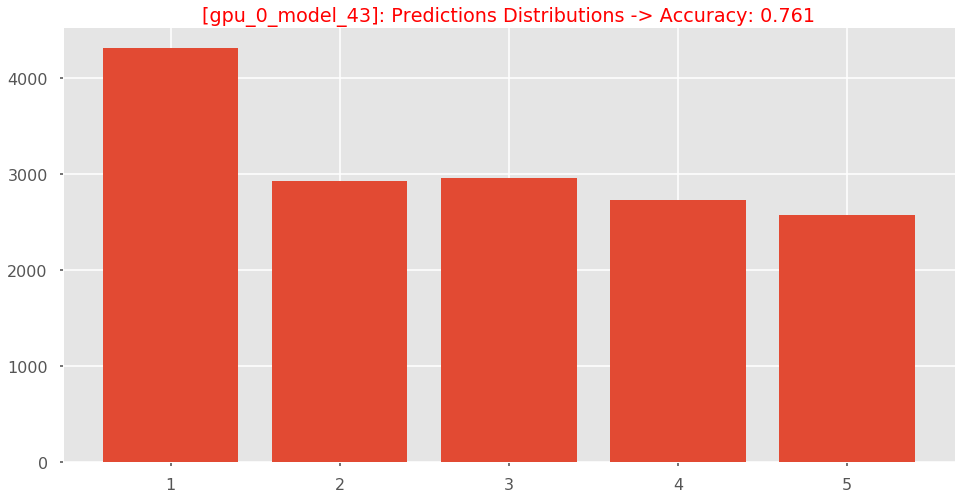

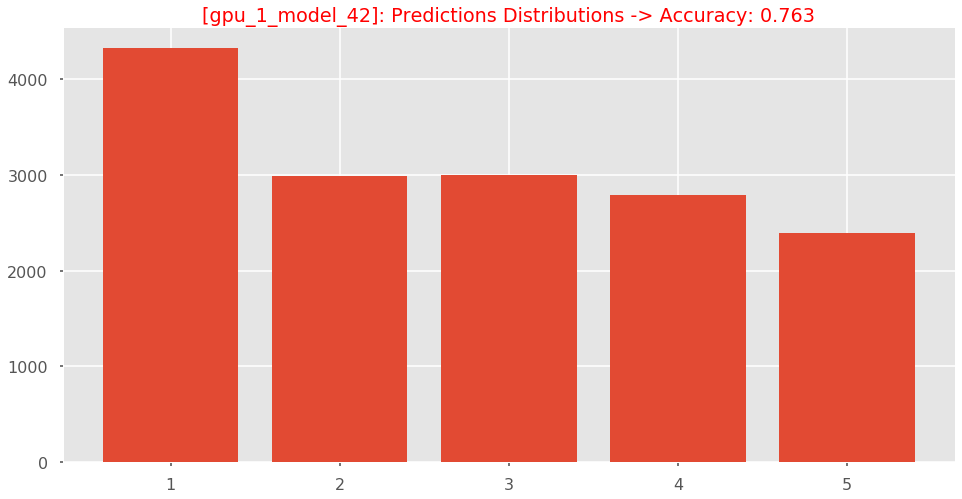

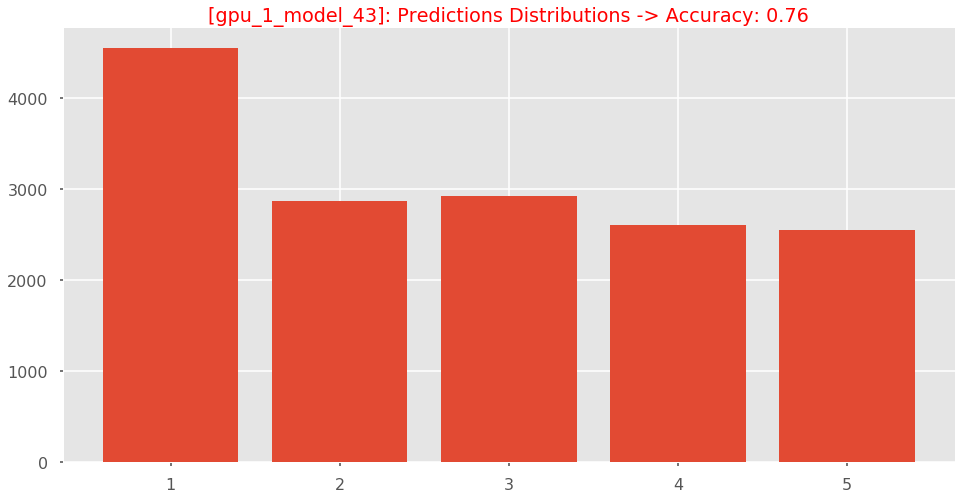

In [22]:
MODELS = [f'gpu_{gpu}_model_{model}' for (gpu, model) in [(0, 43), (1, 42), (1, 43)]]
for model in MODELS:
    plt.figure(figsize = (16, 8))
    accuracy = accuracy_score(predictions[model], predictions['label'])
    plt.bar(*np.unique(predictions[model], return_counts = True))
    plt.title(f"[{model}]: Predictions Distributions -> Accuracy: {RD(accuracy)}", color = 'red')
    plt.show()

In [23]:
train_noisy = predictions[predictions['is_noisy'] == 1].reset_index(drop = True)
train_clear = predictions[predictions['is_noisy'] == 0].reset_index(drop = True)

test_noisy = test_df[test_df['is_noisy'] == 1].reset_index(drop = True)
test_clear = test_df[test_df['is_noisy'] == 0].reset_index(drop = True)

print('=' * 55)
print(f"No. of train noisy samples: {train_noisy.shape[0]}")
print(f"No. of train clear samples: {train_clear.shape[0]}")

print(f"No. of test noisy samples: {test_noisy.shape[0]}")
print(f"No. of test clear samples: {test_clear.shape[0]}")


print('=' * 55)
for model in MODELS:
    print(f"[Noisy] Model {model}: {accuracy_score(train_noisy['label'], train_noisy[model])}")
    print(f"[Clear] Model {model}: {accuracy_score(train_clear['label'], train_clear[model])}")
    print(f"[All]   Model {model}: {accuracy_score(predictions['label'], predictions[model])}")
    print('=' * 55)

No. of train noisy samples: 4278
No. of train clear samples: 11222
No. of test noisy samples: 1500
No. of test clear samples: 4000
[Noisy] Model gpu_0_model_43: 0.5603085553997195
[Clear] Model gpu_0_model_43: 0.8371056852610943
[All]   Model gpu_0_model_43: 0.7607096774193548
[Noisy] Model gpu_1_model_42: 0.5612435717625058
[Clear] Model gpu_1_model_42: 0.8395116734984851
[All]   Model gpu_1_model_42: 0.7627096774193548
[Noisy] Model gpu_1_model_43: 0.5572697522206639
[Clear] Model gpu_1_model_43: 0.83746212796293
[All]   Model gpu_1_model_43: 0.7601290322580645


In [24]:
oof    = results[MODELS].values
labels = results['label'].values

votes = []
voting_wrong, all_wrong, very_wrong = [], [], []
for i in range(oof.shape[0]):
    values, counts = np.unique(oof[i], return_counts = True)
    index = np.argmax(counts)
    votes.append(values[index])
    
    if labels[i] not in oof[i] and \
        labels[i] + 1 not in oof[i] and \
         labels[i] - 1 not in oof[i]:
          very_wrong.append(True)
    else:
          very_wrong.append(False)
            
    if labels[i] not in oof[i]:
        all_wrong.append(True)
    else:
        all_wrong.append(False)
            
    if labels[i] != values[index]:
        voting_wrong.append(True)
    else: 
        voting_wrong.append(False)

results['voting']       = votes
results['voting_wrong'] = voting_wrong
results['all_wrong']    = all_wrong
results['very_wrong']   = very_wrong
          
# plt.figure(figsize = (16, 8))
# plt.bar(*np.unique(results['voting'], return_counts = True))
# plt.title("Predictions Distributions")
# plt.show()

# plt.figure(figsize = (16, 8))
# plt.bar(*np.unique(results['label'], return_counts = True))
# plt.title("Label Distributions")
# plt.show()

R = lambda x: np.round(x, 3)
print(f"Voting Accuracy: {accuracy_score(results['label'], results['voting'])}")
      
voting_wrong_samples       = results[results['voting_wrong'] == 1].reset_index(drop = True)
voting_wrong_noisy_samples = results[(results['voting_wrong'] == 1) & (results['is_noisy'] == 1)].reset_index(drop = True)      
voting_wrong_clear_samples = results[(results['voting_wrong'] == 1) & (results['is_noisy'] == 0)].reset_index(drop = True)      

voting_good_samples       = results[results['voting_wrong'] == 0].reset_index(drop = True)
voting_good_noisy_samples = results[(results['voting_wrong'] == 0) & (results['is_noisy'] == 1)].reset_index(drop = True)      
voting_good_clear_samples = results[(results['voting_wrong'] == 0) & (results['is_noisy'] == 0)].reset_index(drop = True)      

print(f"Voting Wrong: {voting_wrong_samples.shape[0]}  ({R(voting_wrong_samples.shape[0] / results.shape[0])}) -> Noisy: {voting_wrong_noisy_samples.shape[0]} ({R(voting_wrong_noisy_samples.shape[0] / voting_wrong_samples.shape[0])}) -> Clear: {voting_wrong_clear_samples.shape[0]} ({R(voting_wrong_clear_samples.shape[0] / voting_wrong_samples.shape[0])})")
print(f"Voting Good:  {voting_good_samples.shape[0]} ({R(voting_good_samples.shape[0] / results.shape[0])}) -> Noisy: {voting_good_noisy_samples.shape[0]} ({R(voting_good_noisy_samples.shape[0] / voting_good_samples.shape[0])}) -> Clear: {voting_good_clear_samples.shape[0]} ({R(voting_good_clear_samples.shape[0] / voting_good_samples.shape[0])})")

all_wrong_samples       = results[results['all_wrong'] == 1].reset_index(drop = True)
all_wrong_noisy_samples = results[(results['all_wrong'] == 1) & (results['is_noisy'] == 1)].reset_index(drop = True)      
all_wrong_clear_samples = results[(results['all_wrong'] == 1) & (results['is_noisy'] == 0)].reset_index(drop = True)      

print(f"All    Wrong: {all_wrong_samples.shape[0]}  ({R(all_wrong_samples.shape[0] / results.shape[0])})  -> Noisy: {all_wrong_noisy_samples.shape[0]} ({R(all_wrong_noisy_samples.shape[0] / all_wrong_samples.shape[0])})  -> Clear: {all_wrong_clear_samples.shape[0]}  ({R(all_wrong_clear_samples.shape[0] / all_wrong_samples.shape[0])})")

      
very_wrong_samples       = results[results['very_wrong'] == 1].reset_index(drop = True)
very_wrong_noisy_samples = results[(results['very_wrong'] == 1) & (results['is_noisy'] == 1)].reset_index(drop = True)      
very_wrong_clear_samples = results[(results['very_wrong'] == 1) & (results['is_noisy'] == 0)].reset_index(drop = True)      

print(f"Very   Wrong: {very_wrong_samples.shape[0]}   ({R(very_wrong_samples.shape[0] / results.shape[0])}) -> Noisy: {very_wrong_noisy_samples.shape[0]}  ({R(very_wrong_noisy_samples.shape[0] / very_wrong_samples.shape[0])}) -> Clear: {very_wrong_clear_samples.shape[0]}  ({R(very_wrong_clear_samples.shape[0] / very_wrong_samples.shape[0])})")

SHOW = False      
if SHOW:
    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results['voting'], return_counts = True))
    plt.title("Voting Predictions Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results['label'], return_counts = True))
    plt.title("All Label Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['very_wrong'] == 1]['voting'], return_counts = True))
    plt.title("[Very Wrong Samples] Predictions Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['very_wrong'] == 1]['label'], return_counts = True))
    plt.title("[Very Wrong Samples] Label Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['all_wrong'] == 1]['voting'], return_counts = True))
    plt.title("[All Wrong Samples] Predictions Distributions", color = 'red')
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.bar(*np.unique(results[results['all_wrong'] == 1]['label'], return_counts = True))
    plt.title("[All Wrong Samples] Label Distributions", color = 'red')
    plt.show()
      

# display(results)

results['path'] = results['id'].apply(lambda x: os.path.join('data/detect-targets-in-radar-signals/', 'train', x))

Voting Accuracy: 0.7678709677419355
Voting Wrong: 3598  (0.232) -> Noisy: 1849 (0.514) -> Clear: 1749 (0.486)
Voting Good:  11902 (0.768) -> Noisy: 2429 (0.204) -> Clear: 9473 (0.796)
All    Wrong: 2790  (0.18)  -> Noisy: 1480 (0.53)  -> Clear: 1310  (0.47)
Very   Wrong: 840   (0.054) -> Noisy: 611  (0.727) -> Clear: 229  (0.273)


# Grid Search (Stage-2)

In [25]:
logger_gpu_0 = pd.read_csv('../logs/stage-2/gpu-0/logger_gpu_0.csv')
logger_gpu_0['GPU'] = 0
logger_gpu_0['STAGE'] = 2
logger_gpu_0 = logger_gpu_0.iloc[3 :]

logger_gpu_0['accuracy']     = logger_gpu_0['cross-validation'].apply(lambda x: x[1 : -1].split(',')[0]).astype(np.float32)
logger_gpu_0['swa-accuracy'] = logger_gpu_0['cross-validation'].apply(lambda x: x[1 : -1].split(',')[1]).astype(np.float32)

logger_gpu_1 = pd.read_csv('../logs/stage-2/gpu-1/logger_gpu_1.csv')
logger_gpu_1['GPU'] = 1
logger_gpu_1['STAGE'] = 2
logger_gpu_1 = logger_gpu_1.iloc[2 :]

logger_gpu_1['accuracy']     = logger_gpu_1['cross-validation'].apply(lambda x: x[1 : -1].split(',')[0]).astype(np.float32)
logger_gpu_1['swa-accuracy'] = logger_gpu_1['cross-validation'].apply(lambda x: x[1 : -1].split(',')[1]).astype(np.float32)

logger_stage_2 = pd.concat([logger_gpu_0, logger_gpu_1], axis = 0).reset_index(drop = True)
display(logger_stage_2.head(n = 10))

,id,model_name,dropout,size,batch_size_t,batch_size_v,n_targets,criterion,gradient_accumulation_steps,max_gradient_norm,...,save_to_log,oof-accuracy,oof-precision,oof-recall,cross-validation,public-leaderboard,GPU,STAGE,accuracy,swa-accuracy
0,3,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.328323,0.630057,0.328323,"[0.7383870967741936, 0.7312903225806452]",0,0,2,0.738387,0.731290
1,4,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.330710,0.655608,0.330710,"[0.7503225806451613, 0.7458064516129033]",0,0,2,0.750323,0.745806
2,5,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.332129,0.646205,0.332129,"[0.7574193548387097, 0.7506451612903225]",0,0,2,0.757419,0.750645
3,6,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.333806,0.653017,0.333806,"[0.7658064516129032, 0.7629032258064516]",0,0,2,0.765806,0.762903
4,7,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.333935,0.655104,0.333935,"[0.7664516129032258, 0.7638709677419355]",0,0,2,0.766452,0.763871
5,8,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.332903,0.656618,0.332903,"[0.7612903225806451, 0.7625806451612903]",0,0,2,0.761290,0.762581
6,9,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.334387,0.658102,0.334387,"[0.7687096774193548, 0.7587096774193548]",0,0,2,0.768710,0.758710
7,10,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.225806,0.050989,0.225806,"[0.22580645161290322, 0.22580645161290322]",0,0,2,0.225806,0.225806
8,11,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.225806,0.050989,0.225806,"[0.22580645161290322, 0.22580645161290322]",0,0,2,0.225806,0.225806
9,12,swin_large_patch4_window12_384_in22k,0.5,384,4,8,5,CrossEntropyLoss,1,NaN,...,True,0.329161,0.650089,0.329161,"[0.7425806451612903, 0.7387096774193549]",0,0,2,0.742581,0.738710


In [26]:
logger_stage_2.groupby('optimizer')['accuracy'].describe()

,count,mean,std,min,25%,50%,75%,max
optimizer,,,,,,,,
Adam,18.0,0.682832,0.176198,0.225806,0.737903,0.754194,0.764677,0.773548
AdamW,18.0,0.655968,0.201394,0.225806,0.734597,0.743710,0.756452,0.770645


In [27]:
logger_stage_2.groupby('LR')['accuracy'].describe()

,count,mean,std,min,25%,50%,75%,max
LR,,,,,,,,
0.000008,4.0,0.738306,0.003315,0.734516,0.736935,0.738065,0.739435,0.742581
0.000010,4.0,0.740161,0.007396,0.734516,0.734758,0.737903,0.743306,0.750323
0.000020,4.0,0.748226,0.009546,0.739355,0.740323,0.748065,0.755968,0.757419
0.000040,4.0,0.756452,0.010204,0.744839,0.749435,0.757581,0.764597,0.765806
0.000060,4.0,0.761048,0.007960,0.751613,0.755968,0.761935,0.767016,0.768710
0.000080,4.0,0.761694,0.005838,0.756774,0.758226,0.760000,0.763468,0.770000
0.000100,4.0,0.628629,0.268622,0.225806,0.622097,0.760000,0.766532,0.768710
0.000200,4.0,0.498952,0.315403,0.225806,0.225806,0.498226,0.771371,0.773548
0.000400,4.0,0.391129,0.194377,0.225806,0.225806,0.368710,0.534032,0.601290


In [53]:
logger_stage_2.groupby(['scheduler', 'LR'])['accuracy'].describe()

count      mean       std       min  \
scheduler                   LR                                              
CosineAnnealingWarmRestarts 0.000008    2.0  0.740484  0.002965  0.738387   
                            0.000010    2.0  0.745645  0.006615  0.740968   
                            0.000020    2.0  0.756452  0.001369  0.755484   
                            0.000040    2.0  0.765000  0.001140  0.764194   
                            0.000060    2.0  0.767581  0.001597  0.766452   
                            0.000080    2.0  0.765645  0.006159  0.761290   
                            0.000100    2.0  0.497258  0.383891  0.225806   
                            0.000200    2.0  0.225806  0.000000  0.225806   
                            0.000400    2.0  0.225806  0.000000  0.225806   
OneCycleLR                  0.000008    2.0  0.736129  0.002281  0.734516   
                            0.000010    2.0  0.734677  0.000228  0.734516   
                            0.000020    2.0  0.740000  0.000912  0.739355   
                            0.000040    2.0  0.747903  0.004334  0.744839   
                            0.000060    2.0  0.754516  0.004106  0.751613   
                            0.000080    2.0  0.757742  0.001369  0.756774   
                            0.000100    2.0  0.760000  0.008212  0.754194   
                            0.000200    2.0  0.772097  0.002053  0.770645   
                            0.000400    2.0  0.556452  0.063412  0.511613   

                                           25%       50%       75%       max  
scheduler                   LR                                                
CosineAnnealingWarmRestarts 0.000008  0.739435  0.740484  0.741532  0.742581  
                            0.000010  0.743306  0.745645  0.747984  0.750323  
                            0.000020  0.755968  0.756452  0.756935  0.757419  
                            0.000040  0.764597  0.765000  0.765403  0.765806  
                            0.000060  0.767016  0.767581  0.768145  0.768710  
                            0.000080  0.763468  0.765645  0.767823  0.770000  
                            0.000100  0.361532  0.497258  0.632984  0.768710  
                            0.000200  0.225806  0.225806  0.225806  0.225806  
                            0.000400  0.225806  0.225806  0.225806  0.225806  
OneCycleLR                  0.000008  0.735323  0.736129  0.736935  0.737742  
                            0.000010  0.734597  0.734677  0.734758  0.734839  
                            0.000020  0.739677  0.740000  0.740323  0.740645  
                            0.000040  0.746371  0.747903  0.749435  0.750968  
                            0.000060  0.753065  0.754516  0.755968  0.757419  
                            0.000080  0.757258  0.757742  0.758226  0.758710  
                            0.000100  0.757097  0.760000  0.762903  0.765806  
                            0.000200  0.771371  0.772097  0.772823  0.773548  
                            0.000400  0.534032  0.556452  0.578871  0.601290

In [44]:
stage_1_gpu_0 = logger_stage_1[(logger_stage_1['GPU'] == 0) & (logger_stage_1['accuracy'] > 0.75)]
stage_1_gpu_1 = logger_stage_1[(logger_stage_1['GPU'] == 1) & (logger_stage_1['accuracy'] > 0.75)]

stage_2_gpu_0 = logger_stage_2[(logger_stage_2['GPU'] == 0) & (logger_stage_2['accuracy'] > 0.75)]
stage_2_gpu_1 = logger_stage_2[(logger_stage_2['GPU'] == 1) & (logger_stage_2['accuracy'] > 0.75)]

grid_models = pd.concat([stage_1_gpu_0, stage_1_gpu_1, stage_2_gpu_0, stage_2_gpu_1], axis = 0)

grid_submissions = pd.DataFrame()
grid_submissions['id'] = test_df['id']
for row, model_sample in grid_models.iterrows():
    ID    = int(model_sample['id'])
    GPU   = int(model_sample['GPU'])
    STAGE = int(model_sample['STAGE'])
    
    try: 
        path_to_submission = f'../models/stage-{STAGE}/gpu-{GPU}/model_{ID}/submission_stage_{STAGE}_gpu_{GPU}_version_{ID}.csv'
        submission = pd.read_csv(path_to_submission)
        grid_submissions[f'Stage-{STAGE}-GPU-{GPU}-Model-{ID}'] = submission['label']
    except:
        continue
        
    # display(grid_submissions)
    # break
    
display(grid_submissions)

,id,Stage-1-GPU-0-Model-5,Stage-1-GPU-0-Model-6,Stage-1-GPU-0-Model-19,Stage-1-GPU-0-Model-20,Stage-1-GPU-0-Model-27,Stage-1-GPU-1-Model-2,Stage-1-GPU-1-Model-3,Stage-1-GPU-1-Model-4,Stage-1-GPU-1-Model-5,...,Stage-2-GPU-0-Model-17,Stage-2-GPU-1-Model-5,Stage-2-GPU-1-Model-6,Stage-2-GPU-1-Model-7,Stage-2-GPU-1-Model-8,Stage-2-GPU-1-Model-9,Stage-2-GPU-1-Model-15,Stage-2-GPU-1-Model-16,Stage-2-GPU-1-Model-17,Stage-2-GPU-1-Model-18
0,a5ce7900-4a92-4969-887b-882515678aaa.png,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,afac9315-be6d-49de-a02b-56ab6de79285.png,1,5,2,1,5,1,1,1,1,...,1,3,2,4,2,1,2,2,1,1
2,225ea6a6-6e0a-4c9b-b2ac-8ca32c9fa598.png,2,1,3,2,4,2,1,1,2,...,1,2,2,1,1,1,2,1,1,1
3,e5fbafa1-58c6-4aea-a3d5-3910483ef377.png,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,c3dff3c1-df96-47bc-a41d-be05eadaf701.png,1,3,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,cecd691e-478a-427a-9ca4-600e63749570.png,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5496,07037c6c-115d-4ca0-98e0-61c095c14188.png,2,4,2,5,4,4,3,2,2,...,2,4,2,4,4,3,2,4,4,4
5497,66ba6865-379e-4429-a271-1d38b964b066.png,2,2,5,1,5,2,1,1,1,...,1,2,2,2,1,1,1,1,1,1
5498,84ba943b-6b34-4b7f-a9d5-ebf667edcc1a.png,3,3,3,3,3,3,3,3,3,...,3,3,3,3,2,3,3,3,3,3


In [45]:
oof = grid_submissions.drop('id', axis = 1, inplace = False).values

In [50]:
all_agreed, votes = [], []
for i in range(oof.shape[0]):
    values, counts = np.unique(oof[i], return_counts = True)
    index = np.argmax(counts)
    votes.append(values[index])
    all_agreed.append(True if len(values) == 1 else False)
    
grid_submissions['path']         = grid_submissions['id'].apply(lambda x: f'../data/detect-targets-in-radar-signals/test/{x}')
grid_submissions['all-agreed']   = all_agreed
grid_submissions['pseudo-label'] = votes

pseudo_labels = grid_submissions[['path', 'id', 'pseudo-label', 'all-agreed']]
display(pseudo_labels)

display(pseudo_labels[pseudo_labels['all-agreed'] == True])
pseudo_labels.to_csv('../data/detect-targets-in-radar-signals/pseudo_labels.csv', index = False)

,path,id,pseudo-label,all-agreed
0,../data/detect-targets-in-radar-signals/test/a...,a5ce7900-4a92-4969-887b-882515678aaa.png,5,False
1,../data/detect-targets-in-radar-signals/test/a...,afac9315-be6d-49de-a02b-56ab6de79285.png,1,False
2,../data/detect-targets-in-radar-signals/test/2...,225ea6a6-6e0a-4c9b-b2ac-8ca32c9fa598.png,1,False
3,../data/detect-targets-in-radar-signals/test/e...,e5fbafa1-58c6-4aea-a3d5-3910483ef377.png,2,False
4,../data/detect-targets-in-radar-signals/test/c...,c3dff3c1-df96-47bc-a41d-be05eadaf701.png,1,False
...,...,...,...,...
5495,../data/detect-targets-in-radar-signals/test/c...,cecd691e-478a-427a-9ca4-600e63749570.png,2,False
5496,../data/detect-targets-in-radar-signals/test/0...,07037c6c-115d-4ca0-98e0-61c095c14188.png,4,False
5497,../data/detect-targets-in-radar-signals/test/6...,66ba6865-379e-4429-a271-1d38b964b066.png,1,False
5498,../data/detect-targets-in-radar-signals/test/8...,84ba943b-6b34-4b7f-a9d5-ebf667edcc1a.png,3,False


,path,id,pseudo-label,all-agreed
5,../data/detect-targets-in-radar-signals/test/5...,5cb19d23-548a-45f1-a407-69f6c86bd39f.png,1,True
7,../data/detect-targets-in-radar-signals/test/e...,ed14cdf1-fe3b-4036-bb95-a8ccc886ac52.png,5,True
8,../data/detect-targets-in-radar-signals/test/d...,dda96881-11b6-48be-a3b8-e4154f8ba88b.png,1,True
13,../data/detect-targets-in-radar-signals/test/5...,580406ae-89d5-4313-a90b-6ed896642ab2.png,5,True
15,../data/detect-targets-in-radar-signals/test/b...,b1bfa6a8-a6c3-4108-b139-e30b21de7ef7.png,4,True
...,...,...,...,...
5489,../data/detect-targets-in-radar-signals/test/a...,a3ce6d54-21a9-409b-b8dd-9aca618ce893.png,2,True
5490,../data/detect-targets-in-radar-signals/test/2...,233d7abb-12f8-4136-ab6c-56beeef493b2.png,2,True
5491,../data/detect-targets-in-radar-signals/test/a...,a38be5be-eb75-46f6-afab-50ec813fced8.png,5,True
5493,../data/detect-targets-in-radar-signals/test/c...,c3aa0bca-f40e-4306-bde5-02e9462b950e.png,3,True
